# Cross validation
- Cross validation is a step in the process of building a ML model which helps us ensure thet our models fit the data accurately and also ensures that we do not overfit.
- Usage of a data set to try different sorts of cross validations
- **Red Wine quality dataset**
    - Target variable: quality
        - Quality grade between 0 and 10
    - Columns: 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
        - Chemical components of the red wine
- We will treat this dataset as a classification problem, the target variable is a discrete variable between 0 and 10

# Short EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Importing the dataset
df= pd.read_csv("./winequality-red.csv")
df.head()

In [ ]:
# Columns are only different chemical components of the wine
# Target 'quality' is a grade given to the wine by experts
df.columns

In [ ]:
# No NaN in the data set
# Only numerical values 
df.info()

In [ ]:
# All the columns are continues variables except the "target"
for col in df.columns:
    print(f"{col :-<50}{len(df[col].unique())} -- {df[col].dtype}")

- We analyse the target variable
    - Only 6 differents values 3,4,5,6,7,8
    - Will map the target to have grades from 0 to 5
        - To do so, we juste create a dictionnary containing what value to replace and with what

In [ ]:
# Analyse of the target variable
print(f"Unique in target: {np.sort(df.quality.unique())}")

quality_map={
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

df.loc[:, "quality"]= df.quality.map(quality_map)
print(f"New target: {np.sort(df.quality.unique())}")

# Model
- We treat this dataset as a classification problem
- Multiple model are possible, we will start with a DecisionTreeClassifier

In [ ]:
# We divide the data in two sets: train, test
# Shuffle data with df.sample
# reset the index from 0 to ...
df= df.sample(frac= 1).reset_index(drop= True)

# 1000 rows for train
df_train= df.head(1000)

# 599 rows for test
df_test= df.tail(599)

[print(x.shape) for x in [df_test, df_train]]

In [ ]:
# We will train a decision tree classifier on train set from sklearn
from sklearn import tree
from sklearn import metrics

# Simple classifier with depth=3
clf= tree.DecisionTreeClassifier(max_depth= 3)

# Columns to train 
cols= list(df.columns)
cols.remove('quality')

# We train the models on those columns
clf.fit(df_train[cols], df_train.quality)

- Model accuracy
    - train: 57.1%
    - test: 55.42%

In [ ]:
# generate prediction on the training set
train_prediction= clf.predict(df_train[cols])

# on test set
test_prediction= clf.predict(df_test[cols])

# calculate accuracy of models on training
train_accuracy= metrics.accuracy_score(
    df_train.quality, train_prediction
)

# test accuracy
test_accuracy= metrics.accuracy_score(
    df_test.quality, test_prediction
)

[print(x) for x in [train_accuracy, test_accuracy]]

# Trying different depth for the model

- We can then observe that the best accuracy is for a depth of 17
- Our simplistic model is overfitting as it is learning well from training data but generalize poorly on test data

In [ ]:
# We will make a loop over diffirent values of depth in order to compare accuracy for those depth

# Label size for matplotlib
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Lists to store accuracy of models
# starting from 0.5 our current accuracy with depth=3
train_accuracies= [0.5]
test_accuracies= [0.5]

# Loop iterates over differents depths --> 1 to 25
for depth in range(1,25):
    clf= tree.DecisionTreeClassifier(max_depth= depth)
    clf.fit(df_train[cols], df_train.quality)

    train_prediction= clf.predict(df_train[cols])
    test_prediction= clf.predict(df_test[cols])

    train_accuracy= metrics.accuracy_score(df_train.quality, train_prediction)
    test_accuracy= metrics.accuracy_score(df_test.quality, test_prediction)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# We then plot those accuracies to compare them
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend(loc="upper left", prop= {'size':15})
plt.xticks(range(0, 25, 1))
plt.xlabel("max_depth", size= 20)
plt.ylabel("accuracy", size= 20)
plt.show()

## Cross validation
- Cross validation is dividing training data into few parts. We train the model on some of these parts and test on remaining parts.
- We divide our data in 2 different sets, train and test sets. It's also possible to divide it in 3 sets train, test and validations sets.

In [ ]:
# We save our training data in another csv
df_train.to_csv('train.csv')

## Kfolds
- We can split any data into k-equal parts using Kfold from sklearn. 
- Each sample is assigned a value from 0 to k-1 when using k-fold cross validation
- With the fold, (trn_, val_) in enumerate(kf.split(X= df)) -->
    - kf will return 5 different folds
    - For each fold:
        - fold take the indice of the actual fold 
        - trn_ the indices of the values which are in the train set
        - val_ the indices of the values which are in the test set
    - In the the end the kfold column:
        - `df.loc[val_, 'kfold']= fold` --> all rows in the val_ list will be test set set of the ith-fold

In [ ]:
import pandas as pd
from sklearn import model_selection

# Opening ou train data
df= pd.read_csv('train.csv')

# kfold column fullfilled with -1
df["kfold"]= -1

# Randomize data
df= df.sample(frac=1).reset_index(drop= True)

# Initiate the kfold class from model_selection module
# Pretty common to do a cv on 5 splits
kf= model_selection.KFold(n_splits= 5)

# We fill the kfold column
for fold, (trn_, val_) in enumerate(kf.split(X= df)):
    df.loc[val_, 'kfold']= fold

# We then save the result
df.to_csv("train_Kfolds.csv", index= False)


## Stratified K-folds
- Some binary classification dataset will be skewed with 90% of positive and 10% of negative samples
- If we use KFold cross validation, we could have some folds with only positive class of the target variable
- Therefore we use Stratified KFold -->
     - Every fold will have the same ratio of each class in it (90% and 10%)
     - Thus, whatever technique we use, we will have similar results in all folds

In [ ]:
# We will proceed the same way as we did with KFold
import pandas as pd
from sklearn import model_selection

# Opening ou train data
df= pd.read_csv('train.csv')

# strat_kfold column fullfilled with -1
df["strat_kfold"]= -1

# Randomize data
df= df.sample(frac=1).reset_index(drop= True)

# Our targets 
y= df.quality

# Initiate the stratified kfold class from model_selection module
# Pretty common to do a cv on 5 splits
kf= model_selection.StratifiedKFold(n_splits= 5)

# We fill the strat_kfold column
# The difference: this time we give the target column in order to have the same ration of target class in each fold
for fold, (trn_, val_) in enumerate(kf.split(X= df, y= y)):
    df.loc[val_, 'strat_kfold']= fold

# We then save the result
df.to_csv("train_Stratified_Kfolds.csv", index= False)


# On observe graphiquement que pour tous les folds, la distribution de la target est la même
for fold in df.strat_kfold.unique():
    plt.figure()
    rows= df.loc[df['strat_kfold'] == fold].index
    sns.countplot(df.loc[rows].quality)


# Hold out 
- Hold out technic, is the same that stratified k-fold or Kfold, but we keep one of those folds as a hold out
- Hold out is frequently used in time-series data

In [ ]:
import datetime
import random

numdays= 200
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
sales_list= [random.randint(500, 1800) for date in date_list]
nb_people_shop= [random.randint(50,200) for date in date_list]

df= pd.DataFrame(dict(date= date_list, sales= sales_list, people= nb_people_shop))
df.head()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_cols= list(df.columns)
X_cols.remove('sales')

X= df[X_cols]
y= df.sales

# We make a test split which represents 30% of our data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.3, 
                                                     random_state=42)

## Stratified K-folds for regression problems
- With regression, we can use any type of cross validation
    - Mostly, simple K-fold cross validation works with regression problems
- We cannot use stratified k-folds directly but we can change the problem a bit to do so
    - If we see the the distribution of our data is non-consistent, **stratified K-folds is a good approach**
    - To use stratified K-folds with regression problem, **we need to divide our target into multiple bins**
- To choose **the number of bins** in which we will divide the target, we need to follow the Sturge's rule
    - **Sturge rule**: 
        - ### nb_bins= 1 + log2(N)
        - with N the number of samples

- I will make a sample regression dataset to show the implementation of stratified k-fold with regression

In [29]:
# Libraries
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import model_selection

In [30]:
def create_folds(data):
    # kfold column filled with ones
    data['kfold']= -1

    # Randomize the data
    data= data.sample(frac= 1).reset_index(drop= True)

    # Calculate number of bins with Sturge's rule
    num_bins= int(1+ np.floor(np.log2(len(data))))

    # bin target
    # cut to segment and sort data values into bins. 
    data.loc[:, "bins"]= pd.cut(
        data["target"], 
        bins= num_bins, 
        labels= False
    )

    # Initiate the stratified kfold
    kfold= model_selection.StratifiedKFold(n_splits=5)

    # Kfold column
    # Instead of target we us bins
    for fold, (trn_, val_) in enumerate(kfold.split(X= data.target, y= data.bins.values)):
        data.loc[val_, 'kfold']= fold
    
    # Drop bins column
    data= data.drop("bins", axis= 1)

    return data

In [32]:
X, y= datasets.make_regression(
    n_samples= 15000, n_features= 100, n_targets= 1
)

df= pd.DataFrame(
    X,
    columns= [f"f_{i}" for i in range(X.shape[1])]
)

df.loc[:, "target"]= y
df= create_folds(df)

/home/momor/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


/home/momor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kfold', ylabel='count'>

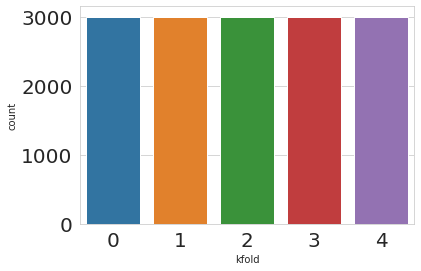

In [37]:
sns.countplot(df["kfold"])